In [1]:
import torch
import os
import random
import datetime
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset

In [2]:
import tqdm

Image 1: US07319101-20080115-C00024.png - Image 2: US07319101-20080115-C00024.png
Image 1: US07314887-20080101-C00075.png - Image 2: US07314887-20080101-C00075.png
Image 1: US07314693-20080101-C00459.png - Image 2: US07314693-20080101-C00459.png
Image 1: US07317124-20080108-C00014.png - Image 2: US07317124-20080108-C00014.png
Image 1: US07314934-20080101-C00071.png - Image 2: US07314934-20080101-C00071.png
Image 1: US07319108-20080115-C00110.png - Image 2: US07319108-20080115-C00110.png
Image 1: US07320977-20080122-C00045.png - Image 2: US07320977-20080122-C00045.png
Image 1: US07317025-20080108-C00017.png - Image 2: US07317025-20080108-C00017.png
Image 1: US07316884-20080108-C00060.png - Image 2: US07316884-20080108-C00060.png
Image 1: US07319104-20080115-C00291.png - Image 2: US07319104-20080115-C00291.png


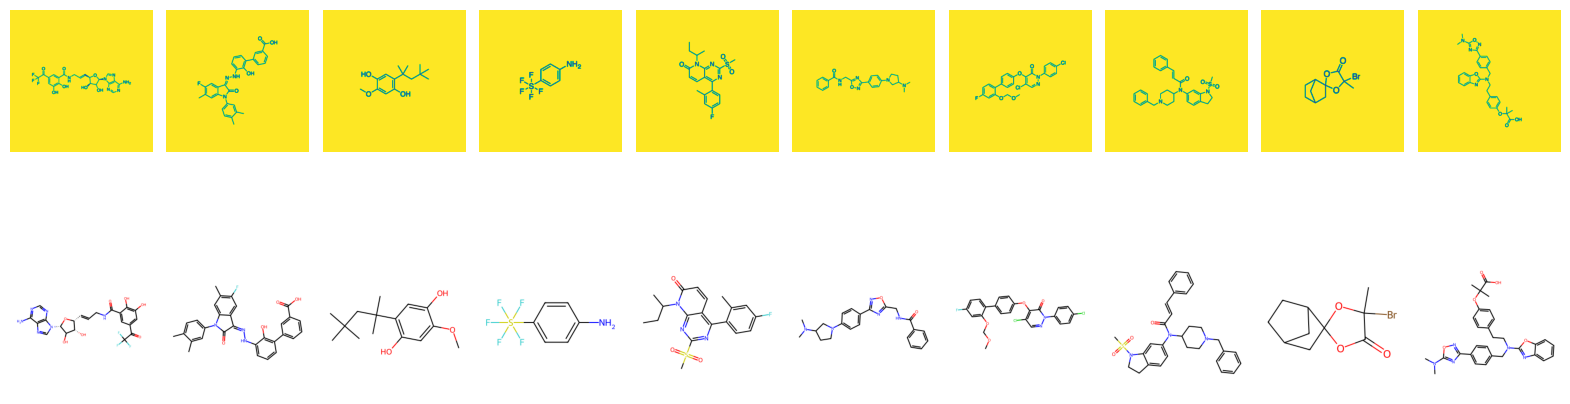

In [3]:
def check_matching_image_counts(root_dir1, root_dir2):
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    return num_images_dir1 == num_images_dir2

def get_matching_indices(root_dir1, root_dir2):
    indices = []
    
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    min_num_images = min(num_images_dir1, num_images_dir2)
    
    for i in range(min_num_images):
        indices.append(i)
        
    return indices

def plot_random_images(root_dir1, root_dir2, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Check if the number of images in each directory matches
    matching_counts = check_matching_image_counts(root_dir1, root_dir2)
    if not matching_counts:
        print("Error: Number of images in each directory does not match.")
        return
    
    # Get matching indices for images from each directory
    indices = get_matching_indices(root_dir1, root_dir2)
    
    # Get random subset of indices
    selected_indices = random.sample(indices, min(num_images, len(indices)))
    
    # Lists to store image names
    img_names1 = []
    img_names2 = []
    
    # Plot images from both directories with the same indices
    for i, idx in enumerate(selected_indices):
        img_name = os.listdir(root_dir1)[idx]
        img_names1.append(img_name)
        img_names2.append(img_name)
        
        img_path_dir1 = os.path.join(root_dir1, img_name)
        img_path_dir2 = os.path.join(root_dir2, img_name)
        
        img_dir1 = Image.open(img_path_dir1)
        img_dir2 = Image.open(img_path_dir2)
        
        axes[0, i].imshow(img_dir1)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(img_dir2)
        axes[1, i].axis('off')
    
    # Print paired image names
    for name1, name2 in zip(img_names1, img_names2):
        print(f"Image 1: {name1} - Image 2: {name2}")
    
    plt.show()

# 경로 설정
root_dir1 = 'data/train/chemdraw_train'
root_dir2 = 'data/train/chemdraw_train_smlies'

# 이미지 플로팅
plot_random_images(root_dir1, root_dir2)

In [4]:
class ImagePairDataset(Dataset):
    def __init__(self, root_dir1, root_dir2, label, transform=None):
        self.root_dir1 = root_dir1
        self.root_dir2 = root_dir2
        self.label = label
        self.transform = transform
        self.samples = []
        
        # 두 디렉토리 안의 이미지 파일을 쌍으로 찾기
        for filename in os.listdir(root_dir1):
            img1_path = os.path.join(root_dir1, filename)
            img2_path = os.path.join(root_dir2, filename)
            if os.path.isfile(img1_path) and os.path.isfile(img2_path):
                # 올바른 쌍인 경우 레이블을 설정
                img1 = self.read_image(img1_path)
                img2 = self.read_image(img2_path)
                self.samples.append((img1, img2, self.label))


    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, idx):
        return self.samples[idx]

    
    def read_image(self, filepath):
        img = Image.open(filepath).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [5]:
class CombinedImagePairDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.total_length = len(dataset1) + len(dataset2)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            img1, img2, label = self.dataset1[idx]
            return img1, img2, label
        else:
            # Adjust the index to fit within the second dataset
            adjusted_idx = idx - len(self.dataset1)
            img1, img2, label = self.dataset2[adjusted_idx]
            return img1, img2, label

In [6]:
class ImageComparisonModel(nn.Module):
    def __init__(self):
        super(ImageComparisonModel, self).__init__()
        
        # Stream 1 for the first image modality
        self.stream1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Stream 2 for the second image modality
        self.stream2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fusion and decision mechanism
        self.comparison = nn.Sequential(
            nn.Linear(16*16*256*2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),  # Binary classification
        )
        
    def forward(self, x1, x2):
        x1 = self.stream1(x1)
        x2 = self.stream2(x2)
        
        # Flatten the features from both streams
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        # Concatenate the features
        x = torch.cat((x1, x2), dim=1)
        
        # Pass through the comparison mechanism
        x = self.comparison(x)
        # Apply softmax to get probabilities
        # x = F.softmax(x, dim=1)
        return x

In [7]:
# # 모델 초기화
combined_model = ImageComparisonModel()

print(combined_model)

ImageComparisonModel(
  (stream1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stream2): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNo

In [8]:
# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 이미지 크기를 64x64로 조정
    transforms.ToTensor(),         # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

In [9]:
batch_size = 8

In [10]:
# 경로 설정

chemdraw_train = "data/train/chemdraw_train"
chemdraw_test = "data/test/chemdraw_test"
chemdraw_valid = "data/valid/chemdraw_val"

chemdraw_train_smlies = "data/train/chemdraw_train_smlies"
chemdraw_test_smlies = "data/test/chemdraw_test_smlies"
chemdraw_valid_smlies = "data/valid/chemdraw_val_smlies"

chemdraw_train_smlies_wrong = "data/train/chemdraw_train_smlies_wrong"
chemdraw_test_smlies_wrong = "data/test/chemdraw_test_smlies_wrong"
chemdraw_valid_smlies_wrong = "data/valid/chemdraw_val_smlies_wrong"

In [11]:
# 학습 데이터셋 생성
combine_train_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_train, chemdraw_train_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_train, chemdraw_train_smlies_wrong, 0, transform=transform))
combine_test_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_test, chemdraw_test_smlies, 1, transform=transform),
                                                ImagePairDataset(chemdraw_test, chemdraw_test_smlies_wrong, 0, transform=transform))
combine_valid_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies_wrong, 0, transform=transform))

# 데이터로더 생성
train_loader = DataLoader(combine_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(combine_test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(combine_valid_dataset, batch_size=batch_size, shuffle=False)

In [12]:
print(combine_train_dataset.dataset1.root_dir1)
print(combine_train_dataset.dataset1.root_dir2)

print(combine_test_dataset.dataset1.root_dir1)
print(combine_test_dataset.dataset1.root_dir2)

print(combine_valid_dataset.dataset1.root_dir1)
print(combine_valid_dataset.dataset1.root_dir2)

data/train/chemdraw_train
data/train/chemdraw_train_smlies
data/test/chemdraw_test
data/test/chemdraw_test_smlies
data/valid/chemdraw_val
data/valid/chemdraw_val_smlies


In [13]:
print(train_loader.dataset.total_length)

7284


In [14]:
print(train_loader.dataset)

In [15]:
# GPU를 사용할 수 있는지 확인합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = combined_model.to(device)

print(device)

cuda


In [16]:
# 학습을 위한 하이퍼파라미터 설정
learning_rate = 1e-5
num_epochs = 50

# 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(criterion)

BCEWithLogitsLoss()


In [17]:
save_model_path = "Check_Model"

def save_model(model, save_path, acc):
    # 새로운 폴더 생성 (없으면)
    os.makedirs(save_path, exist_ok=True)
    # 현재 시간 가져오기
    now = datetime.datetime.now()
    # 모델 저장
    torch.save(model.state_dict(), os.path.join(save_path, f"model_{now.strftime('%Y%m%d_%H%M%S')}_{acc}.pth"))


def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        
        # 훈련 데이터로 모델 학습
        for inputs1, inputs2, labels in tqdm.tqdm(train_loader, total=len(train_loader)):
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            outputs = outputs.squeeze()
            # 모델 출력의 크기와 레이블의 크기를 맞추기 위해 labels을 [batch_size, 2]로 변경
            #labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            #print(f'[DEBUG] Train Loss: {loss.item():.8f}')
        
        # 평균 훈련 손실 계산
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0
        
        # 검증 데이터로 모델 평가
        with torch.no_grad():
            for inputs1, inputs2, labels in tqdm.tqdm(valid_loader, total=len(valid_loader)):
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                outputs = model(inputs1, inputs2)
                outputs = outputs.squeeze()
                # 모델 출력의 크기와 레이블의 크기를 맞추기 위해 labels을 [batch_size, 2]로 변경
                #labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
                loss = criterion(outputs, labels.float())
                running_valid_loss += loss.item()
                
                # 정확도 계산
                #_, predicted = torch.max(outputs, 1)
                #predicted = predicted.unsqueeze(1)  # predicted를 [batch_size, 1]로 변경
                predicted = (outputs > 0).long()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        # 평균 검증 손실 계산
        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        # 정확도 계산
        accuracy = correct / total
        
        # 에포크마다 학습 결과 출력
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.8f}, Valid Loss: {epoch_valid_loss:.8f}, Accuracy: {accuracy:.8f}')
        
        # 더 나은 모델인 경우 저장
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            if save_path:
                save_model(model, save_path, best_accuracy)
        
        # 모델의 손실이 더 낮아졌을 때 저장
        #if epoch_valid_loss < best_valid_loss:
        #    best_valid_loss = epoch_valid_loss
        #    if save_path:
        #        save_model(model, save_path)

        print("모델이 저장되었습니다.")
    return train_losses, valid_losses, best_accuracy

In [18]:
# 모델 학습
#num_epochs = 3
train_losses, valid_losses, best_accuracy = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_model_path)

100%|██████████| 130/130 [00:01<00:00, 92.84it/s]


Epoch 1/50, Train Loss: 0.66265374, Valid Loss: 0.58870063, Accuracy: 0.73269231
모델이 저장되었습니다.


 41%|████      | 374/911 [00:27<00:39, 13.59it/s]


KeyboardInterrupt: 

In [ ]:
# 학습 결과 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
def evaluate_model(model, criterion, test_loader):
    total_samples = 0
    total_loss = 0
    correct_predictions = 0
    
    with torch.no_grad():
        for inputs1, inputs2 in test_loader:
            inputs1, inputs2 = inputs1.to(device), inputs2.to(device)
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, torch.ones(outputs.shape[0], 1, device=device))  # 이진 분류 문제에서는 일관된 레이블 사용
            total_loss += loss.item() * inputs1.size(0)
            
            # 모델의 예측 결과를 확인하여 정확도 계산
            predicted_labels = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predicted_labels == 1).sum().item()
            
            total_samples += inputs1.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples * 100
    
    return avg_loss, accuracy


In [ ]:
# 테스트 데이터셋에 대해 모델 평가
test_loss, test_accuracy = evaluate_model(model, criterion, test_loader)
print(f'Test Loss: {test_loss:.8f}, Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
# 결과를 저장할 데이터프레임 생성
results_df = pd.DataFrame(columns=['Image1', 'Image2', 'Prediction'])

In [ ]:
model.load_state_dict(torch.load('model_20240325_172813.pth'))
model.eval()  # 모델을 평가 모드로 설정

In [ ]:
# 이미지가 있는 두 개의 폴더 경로 설정
folder1_path = "chemdraw_LastTestSet"
folder2_path = "chemdraw_LastTestSet_smlies"

# 이미지 폴더 내의 파일 목록 가져오기
folder1_files = os.listdir(folder1_path)
folder2_files = os.listdir(folder2_path)

In [ ]:
# 결과를 저장할 CSV 파일 경로 설정
output_csv_path = "result_correct2.csv"

# 결과를 저장할 리스트 초기화
results = []


# 폴더1의 이미지와 폴더2의 이미지를 비교하며 모델 평가
for file1, file2 in zip(folder1_files, folder2_files):
    # 이미지 파일의 경로 설정
    image1_path = os.path.join(folder1_path, file1)
    image2_path = os.path.join(folder2_path, file2)

    # 이미지 불러오기
    image1 = Image.open(image1_path).convert("RGB")
    image2 = Image.open(image2_path).convert("RGB")

    # 전처리 적용
    image1 = transform(image1).unsqueeze(0)  # 배치 차원 추가
    image2 = transform(image2).unsqueeze(0)  # 배치 차원 추가

    # 모델에 이미지 입력하여 예측 수행
    with torch.no_grad():
        output = model(image1, image2)
        predicted_label = torch.sigmoid(output).item()  # 이진 분류에서 확률값으로 변환

    # 결과를 리스트에 저장
    results.append([file1, file2, predicted_label])
    

# 결과를 CSV 파일에 저장
with open(output_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Image1", "Image2", "Predicted_Probability"])
    writer.writerows(results)

print("Results saved to:", output_csv_path)